In [ ]:
!pip install tensorflow 
!pip install tensorflow-gpu 
!pip install opencv-python 
!pip install matplotlib

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
import cv2
import imghdr

In [4]:
data_dir = 'data' 

In [5]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [6]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [7]:
import numpy as np
from matplotlib import pyplot as plt

In [8]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [9]:
data_iterator = data.as_numpy_iterator()

In [10]:
batch = data_iterator.next()

In [11]:
# 0 stands for happy pictures
# 1 stands for sad pictures
batch[1]

array([0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

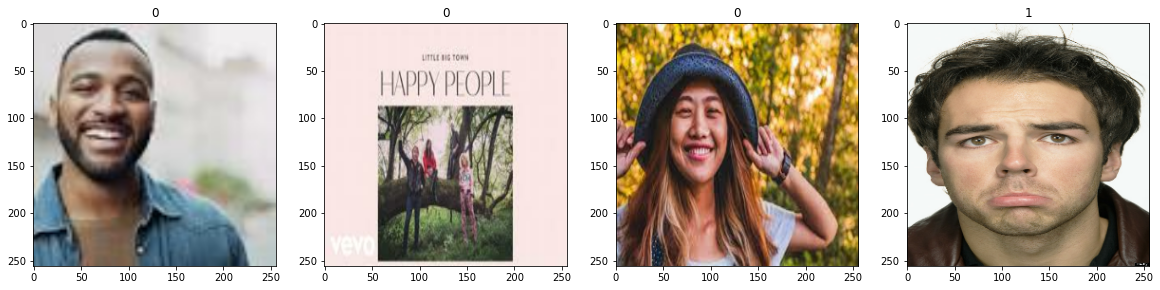

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [13]:
# Scale data to 0~1
data = data.map(lambda x,y: (x/255, y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [14]:
data.as_numpy_iterator().next()[0].max()

1.0

In [15]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [16]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [18]:
model = Sequential()

In [19]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [20]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [24]:
logdir='logs'

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 10s 1s/step - loss: 0.7015 - accuracy: 0.5670 - val_loss: 0.6085 - val_accuracy: 0.5938
Epoch 2/20
7/7 [==============================] - 9s 1s/step - loss: 0.6097 - accuracy: 0.5714 - val_loss: 0.5802 - val_accuracy: 0.7500
Epoch 3/20
7/7 [==============================] - 10s 1s/step - loss: 0.6075 - accuracy: 0.7455 - val_loss: 0.5151 - val_accuracy: 0.8125
Epoch 4/20
7/7 [==============================] - 13s 2s/step - loss: 0.4642 - accuracy: 0.8036 - val_loss: 0.3619 - val_accuracy: 0.9375
Epoch 5/20
7/7 [==============================] - 21s 3s/step - loss: 0.3227 - accuracy: 0.8839 - val_loss: 0.3089 - val_accuracy: 0.8438
Epoch 6/20
7/7 [==============================] - 12s 1s/step - loss: 0.2466 - accuracy: 0.9107 - val_loss: 0.2247 - val_accuracy: 0.9375
Epoch 7/20
7/7 [==============================] - 12s 2s/step - loss: 0.1903 - accuracy: 0.9554 - val_loss: 0.1403 - val_accuracy: 0.9375
Epoch 8/20
7/7 [===================

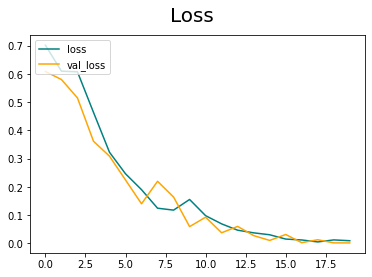

In [27]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

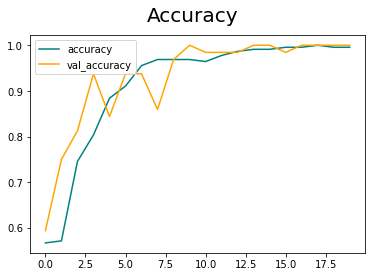

In [28]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [29]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [30]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [31]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 174ms/step


In [32]:
print(pre.result().numpy(), re.result().numpy(), acc.result().numpy())

1.0 1.0 1.0


In [33]:
import cv2

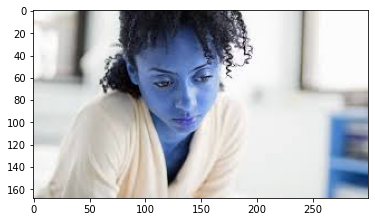

In [34]:
img = cv2.imread('sadtest.jpg')
plt.imshow(img)
plt.show()

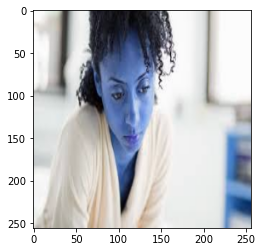

In [35]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [36]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 21ms/step


In [37]:
yhat

array([[0.9997202]], dtype=float32)

In [38]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


In [39]:
from tensorflow.keras.models import load_model

In [40]:
model.save(os.path.join('models','imageclassifier.h5'))

In [41]:
new_model = load_model(os.path.join('models','imageclassifier.h5'))

In [42]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 57ms/step


array([[0.9997202]], dtype=float32)